# Toy diffusion model generating data from a complex 2-d distribution

## General imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

## Load training data

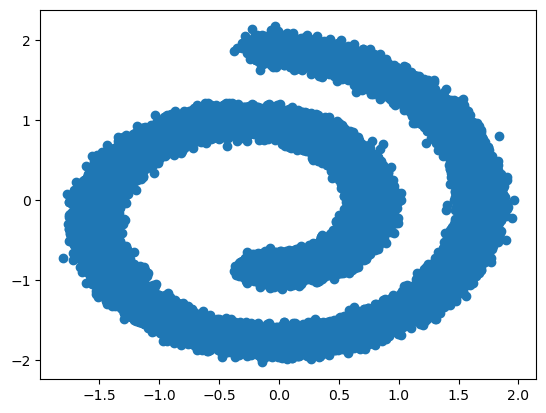

In [2]:
from sklearn.datasets import make_swiss_roll

x, _ = make_swiss_roll(n_samples=100000, noise=0.5)
# Make two-dimensional to easen visualization
x = x[:, [0, 2]]

x = (x - x.mean()) / x.std()

plt.scatter(x[:, 0], x[:, 1])

## Prepare data for learning

In [3]:
import torch

X = torch.tensor(x, dtype=torch.float32)

## Diffusion model hyperparameters

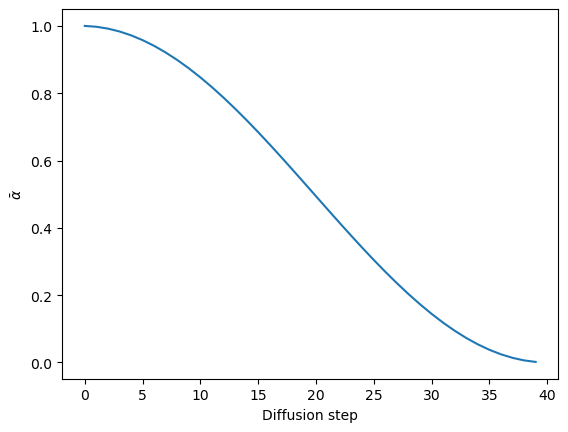

In [4]:
diffusion_steps = 40  # Number of steps in the diffusion process

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

# Check the cumulative alphas follow the distribution recommended in the paper
sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

Function that noises a data point following the diffusion process

In [5]:
def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps

Test noising the training data

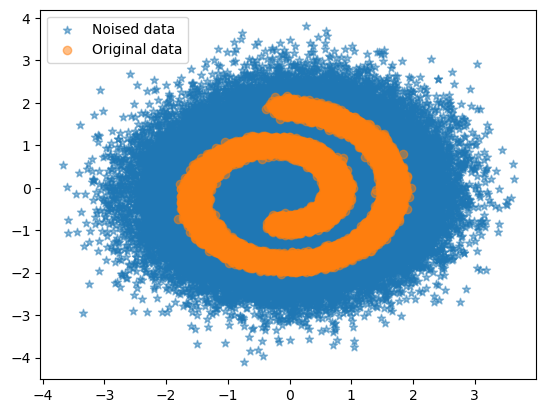

In [6]:
noiselevel = 20

noised, eps = noise(X, torch.full([len(X), 1], fill_value=noiselevel))
plt.scatter(noised[:, 0], noised[:, 1], marker="*", alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.legend(["Noised data", "Original data"])
plt.show()

Since we know the noise we just added, we can recover the original data as follows:

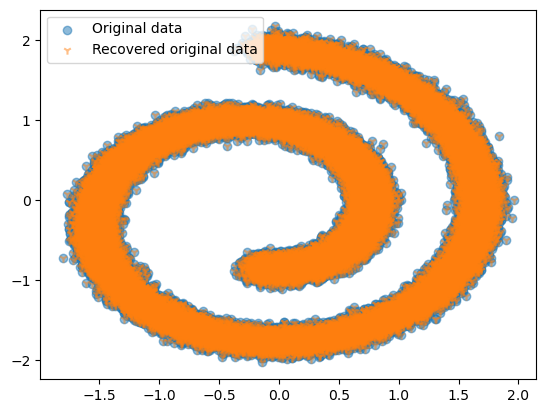

In [7]:
denoised = 1 / torch.sqrt(baralphas[noiselevel]) * (noised - torch.sqrt(1 - baralphas[noiselevel]) * eps)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(denoised[:, 0], denoised[:, 1], marker="1", alpha=0.5)
plt.legend(["Original data", "Recovered original data"])
plt.show()

We can also check numerically that the result is the same

In [8]:
X - denoised

tensor([[ 0.0000e+00,  0.0000e+00],
        [-1.4901e-08, -5.9605e-08],
        [-5.9605e-08, -1.1921e-07],
        ...,
        [-1.1921e-07, -2.9802e-08],
        [ 0.0000e+00,  7.4506e-09],
        [ 0.0000e+00,  0.0000e+00]])

## Diffusion network

Now we define a pytorch network that will learn to predict the noise component from noised data.

In [9]:
import torch.nn as nn

class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
    
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

Let's create a model with 4 inner blocks, which is enough for this problem.

In [10]:
model = DiffusionModel(nfeatures=2, nblocks=4)

device = "cuda"
model = model.to(device)

model

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-3): 4 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

## Train denoising network

In [11]:
import torch.optim as optim

nepochs = 100
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

for epoch in range(nepochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)
        predicted_noise = model(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 0.7618578672409058
Epoch 1 loss = 0.5349692702293396
Epoch 2 loss = 0.5123570561408997
Epoch 3 loss = 0.5041273832321167
Epoch 4 loss = 0.49381327629089355
Epoch 5 loss = 0.48304489254951477
Epoch 6 loss = 0.4848330616950989
Epoch 7 loss = 0.48042404651641846
Epoch 8 loss = 0.474806010723114
Epoch 9 loss = 0.47407904267311096
Epoch 10 loss = 0.4765787720680237
Epoch 11 loss = 0.47189512848854065
Epoch 12 loss = 0.4748026728630066
Epoch 13 loss = 0.46816185116767883
Epoch 14 loss = 0.4629824757575989
Epoch 15 loss = 0.46058210730552673
Epoch 16 loss = 0.4620664417743683
Epoch 17 loss = 0.4604698419570923
Epoch 18 loss = 0.4569888114929199
Epoch 19 loss = 0.45485788583755493
Epoch 20 loss = 0.45522862672805786
Epoch 21 loss = 0.4531041979789734
Epoch 22 loss = 0.4523163437843323
Epoch 23 loss = 0.44915851950645447
Epoch 24 loss = 0.4514417052268982
Epoch 25 loss = 0.4483877122402191
Epoch 26 loss = 0.45137497782707214
Epoch 27 loss = 0.44705381989479065
Epoch 28 loss = 0.4

Best model: 
* DiffusionModel(nfeatures=2, nblocks=5), 40 diffusion steps, batchsize=2048, Epoch 99 loss = 0.4353588819503784
* DiffusionModel(nfeatures=2, nblocks=2), 40 diffusion steps, batchsize=2048, Epoch 99 loss = 0.4339998960494995
* DiffusionModel(nfeatures=2, nblocks=2), no residuals, 40 diffusion steps, batchsize=2048, Epoch 99 loss = 0.4348624050617218
* DiffusionModel(nfeatures=2, nblocks=2), no residuals, no t replug, 40 diffusion steps, batchsize=2048, Epoch 99 loss = 0.4352072775363922
* DiffusionModel(nfeatures=2, nblocks=2), no residuals, no t replug, no norm layers, 40 diffusion steps, batchsize=2048, Epoch 99 loss = 0.43683546781539917

## Sampling algorithm

We will use the classic DDPM sampler, defined as follows

In [12]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

## Test generation

Let's generate 10K samples of the learned distribution using the diffusion model we just created

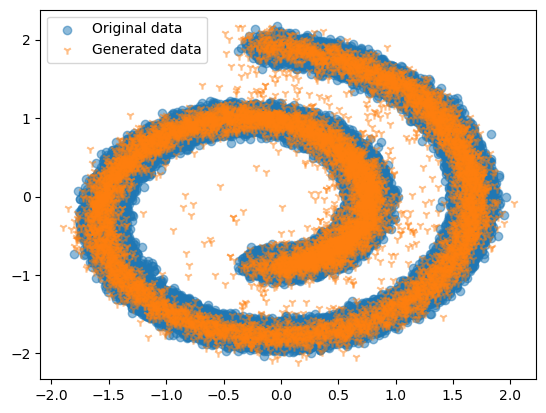

In [13]:
Xgen, Xgen_hist = sample_ddpm(model, 10000, 2)
Xgen = Xgen.cpu()
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="1", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()

We can also create an animation of the denoising process

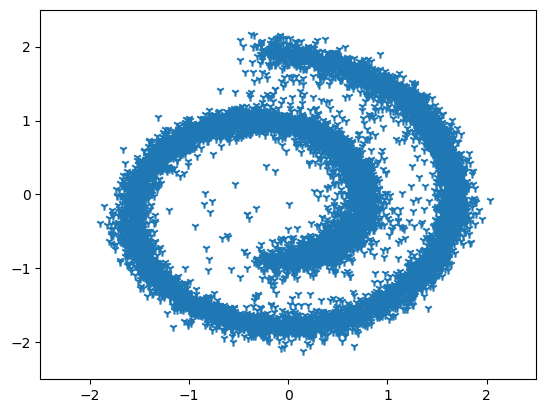

In [14]:
import matplotlib.animation as animation

def draw_frame(i):
    plt.clf()
    Xvis = Xgen_hist[i].cpu()
    fig = plt.scatter(Xvis[:, 0], Xvis[:, 1], marker="1", animated=True)
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    return fig,

fig = plt.figure()
anim = animation.FuncAnimation(fig, draw_frame, frames=40, interval=20, blit=True)
anim.save('swissroll_generation.mp4', fps=10)

In [18]:
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="swissroll_generation.mp4" type="video/mp4">
</video></div>""")

## Extras: alternative sampler

In [16]:
def sample_ddpm_x0(model, nsamples, nfeatures):
    """Sampler that uses the equations in DDPM paper to predict x0, then use that to predict x_{t-1}
    
    This is how DDPM is implemented in HuggingFace Diffusers, to allow working with models that predict
    x0 instead of the noise. It is also how we explain it in the Mixture of Diffusers paper.
    """
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # Predict original sample using DDPM Eq. 15
            x0 = (x - (1 - baralphas[t]) ** (0.5) * predicted_noise) / baralphas[t] ** (0.5)
            # Predict previous sample using DDPM Eq. 7
            c0 = (baralphas[t-1] ** (0.5) * betas[t]) / (1 - baralphas[t])
            ct = alphas[t] ** (0.5) * (1 - baralphas[t-1]) / (1 - baralphas[t])
            x = c0 * x0 + ct * x
            # Add noise
            if t > 1:
                # Instead of variance = betas[t] the Stable Diffusion implementation uses this expression
                variance = (1 - baralphas[t-1]) / (1 - baralphas[t]) * betas[t]
                variance = torch.clamp(variance, min=1e-20)
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
        return x

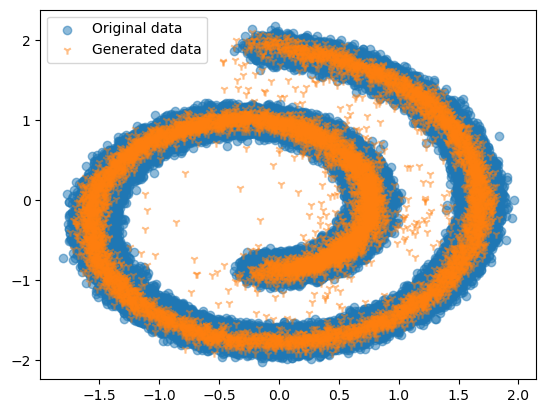

In [17]:
Xgen = sample_ddpm_x0(model, 10000, 2).cpu()
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="1", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()